# 1.0 Classic Dimensionality Reduction Techniques

In this demo code, we will go over classic techniques (tailored bases) for dimensionality reduction:

* SVD (single image compression)
* SVD (multiple images compression)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import tensorflow as tf
import pandas as pd
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
import cv2

### SVD (single image compression)

(480, 800, 3)


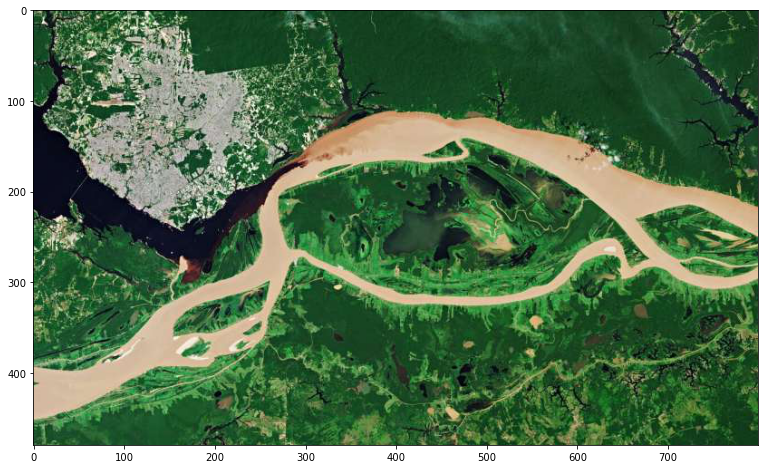

In [3]:
#download image (extracted from https://phys.org/news/2019-09-image-rio-negro-solimes-river.html)

A = imread('amazon.jpg')

plt.figure(figsize=(14, 8))
plt.imshow(A)
print(A.shape)

(480, 800)


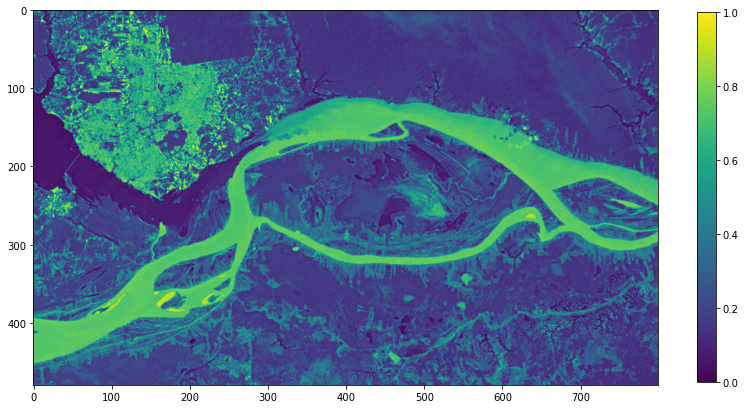

In [4]:
#convert to single channel image and normalize

A_gsc = np.mean(A, axis=-1)/255.0

plt.figure(figsize=(14, 8))
plt.imshow(A_gsc, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(shrink=0.85)
print(A_gsc.shape)

In [5]:
#run SVD on the image and construct diag matrix

U, S, VT = np.linalg.svd(A_gsc, full_matrices=True)
S = np.diag(S)

print(U.shape)
print(S.shape)
print(VT.shape)

(480, 480)
(480, 480)
(800, 800)


Text(0.5, 1.0, 'Cumulative sum of singular values')

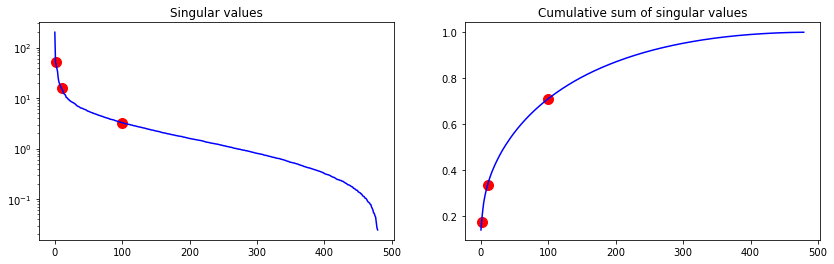

In [6]:
#get the singular values and cumulative energy

ks = [1, 10, 100]

plt.figure(figsize=(14, 4))

S_ = np.diag(S)
plt.subplot(1, 2, 1)
plt.semilogy(S_, c='b')
plt.scatter(ks, S_[ks], s=100, c='r') #approx
plt.title('Singular values')

S_ = np.cumsum(np.diag(S))/np.sum(np.diag(S))
plt.subplot(1, 2, 2)
plt.plot(S_, c='b')
plt.scatter(ks, S_[ks], s=100, c='r') #approx
plt.title('Cumulative sum of singular values')

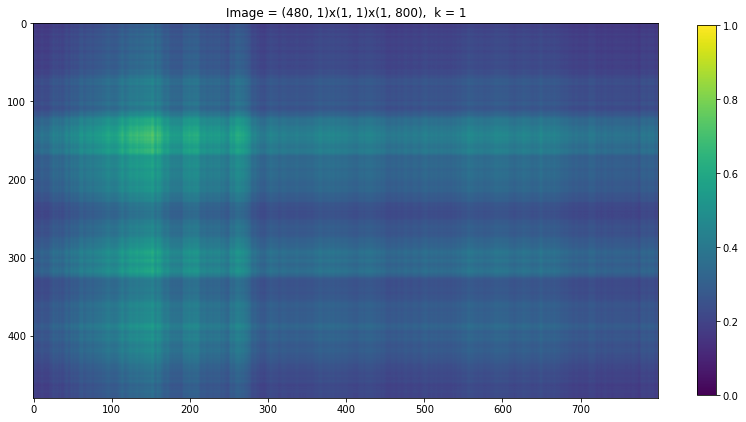

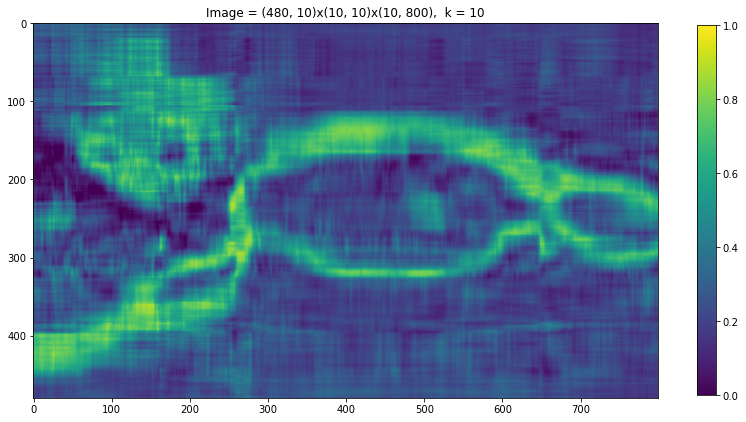

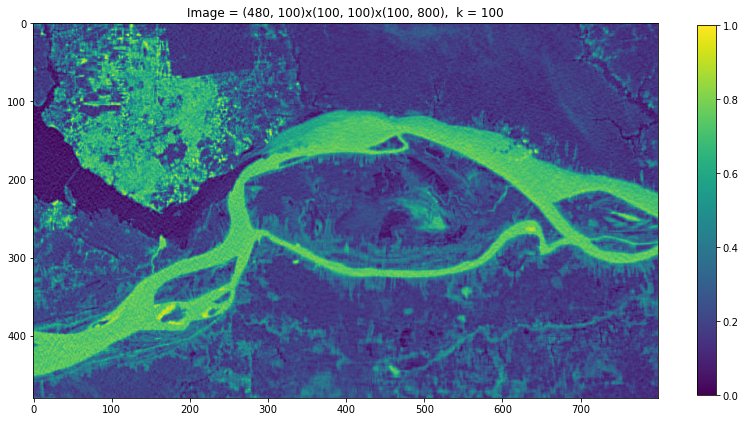

In [7]:
#get approximations based on several k-truncations

for k in ks:
    
    U_ = U[:,:k]
    S_ = S[0:k,:k]
    VT_ = VT[:k,:]
    
    A_gsc_hat = U_ @ S_ @ VT_
    
    plt.figure(figsize=(14, 8))
    img = plt.imshow(A_gsc_hat, cmap='viridis', vmin=0, vmax=1)
    plt.title("Image = {}x{}x{},  k = {}".format(U_.shape, S_.shape, VT_.shape, k))
    plt.colorbar(shrink=0.85)

### SVD (multiple images compression)

In [8]:
#load MNIST dataset 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#normalize the images
x_train = np.expand_dims(x_train/255.0, axis=-1)
x_test = np.expand_dims(x_test/255.0, axis=-1)

#flatten the 2D images
x_train_f = np.transpose(np.reshape(x_train, [x_train.shape[0], -1]))
x_test_f = np.transpose(np.reshape(x_test, [x_test.shape[0], -1]))

#center the flattened images!
x_train_f_c = x_train_f - np.expand_dims(np.mean(x_train_f, axis=1), axis=1)
x_test_f_c = x_test_f - np.expand_dims(np.mean(x_test_f, axis=1), axis=1)

#define the labels
class_names = ['zero', 'one', 'two', 'three', 'four',
               'five', 'six', 'seven', 'eight', 'nine']

print(x_train.shape)
print(x_test.shape)

print(x_train_f_c.shape)
print(x_test_f_c.shape)

print(y_train.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(784, 60000)
(784, 10000)
(60000,)
(10000,)


In [9]:
#plot function for sample images

def plot_tile(samples):
    
    num_samples, x_dim, y_dim, _ = samples.shape
    axes = (np.round(np.sqrt(num_samples))).astype(int)
    fig = plt.figure(figsize=(axes, axes))
    gs = gridspec.GridSpec(axes, axes)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(sample, cmap=plt.get_cmap('viridis'), aspect='auto')

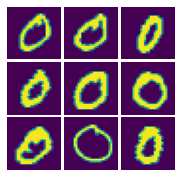

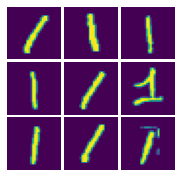

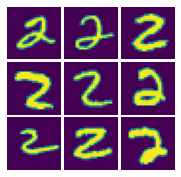

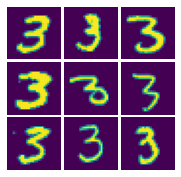

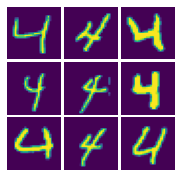

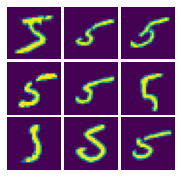

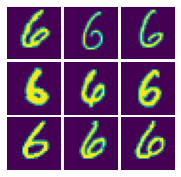

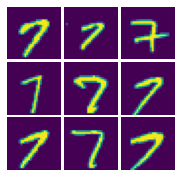

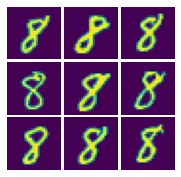

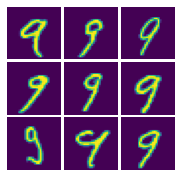

In [10]:
#visualize first 9 samples of input images based on class labels, within the training dataset

unique_labels, label_counts = np.unique(y_train, return_counts=True)

for label in unique_labels:
    x_train_perlabel = x_train[np.squeeze(y_train) == label]
    fig = plot_tile(x_train_perlabel[0:9, :, :])

In [11]:
#run SVD on the matrix of images and construct diag matrix

U, S, VT = np.linalg.svd(x_train_f_c, full_matrices=False)
S = np.diag(S)

print(U.shape)
print(S.shape)
print(VT.shape)

(784, 784)
(784, 784)
(784, 60000)


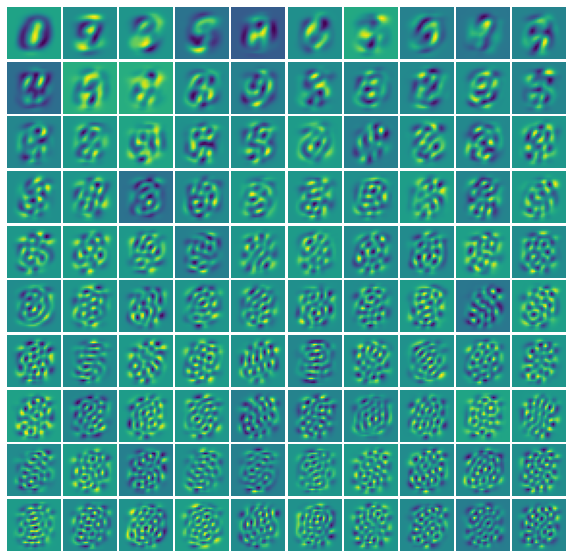

In [12]:
#display U as the orthonormal basis for the column space of x_test_f

k = 100
U_ = np.reshape(U[:, :k].T, (-1, x_train.shape[1], x_train.shape[2], 1))

plot_tile(U_)

In [13]:
#projection (v) on the first k bases

k = 20                                           #try a few numbers~
v = (np.linalg.pinv(U[:, :k])@x_train_f_c).T
print(v.shape)

(60000, 20)


Text(0.5, 1.0, 'Projections')

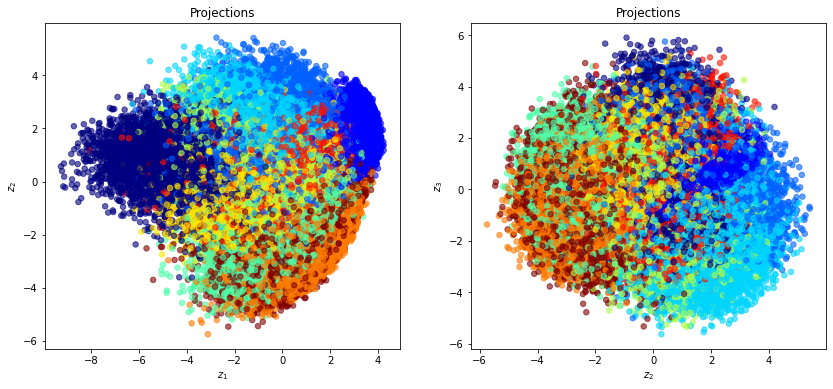

In [14]:
#lets visualize the projections by class label (a.k.a eigenspaces)

import matplotlib.cm as cm
from matplotlib.colors import Normalize

my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_train))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(v[:, 0], v[:, 1], s=30, c=cs, alpha=0.6)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Projections')

plt.subplot(1, 2, 2)
plt.scatter(v[:, 1], v[:, 2], s=30, c=cs, alpha=0.6)
plt.xlabel('$z_2$')
plt.ylabel('$z_3$')
plt.title('Projections')

In [15]:
#reconstruction with the first k bases

x_train_f_c_hat = U[:, :k]@v.T
x_train_f_hat = x_train_f_c_hat + np.expand_dims(np.mean(x_train_f, axis=1), axis=1)

x_train_hat = np.reshape(x_train_f_hat.T, [-1, 28, 28])

print(x_train_f_c_hat.shape)
print(x_train_f_hat.shape)
print(x_train_hat.shape)

(784, 60000)
(784, 60000)
(60000, 28, 28)


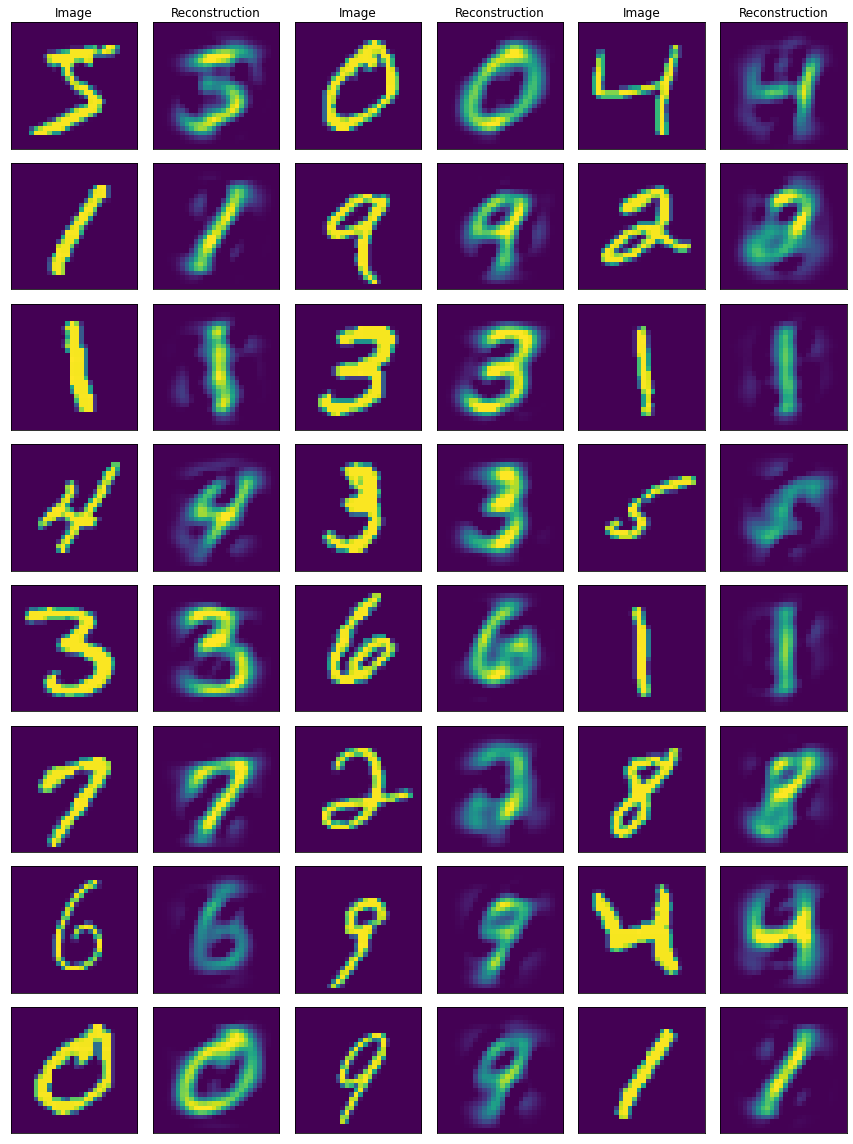

In [16]:
#compare original and reconstructions

#plot some test images with predicted vs true labels
#correct predictions (colored blue) and incorrect predictions (colored red)

num_rows = 8
num_cols = 3
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], vmin=0, vmax=1)
    if i < 3:
        plt.title('Image')
    
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train_hat[i], vmin=0, vmax=1)
    if i < 3:
        plt.title('Reconstruction')
    
plt.tight_layout()
plt.show()

### PCA (multiple images compression)

Text(0.5, 1.0, 'Projections')

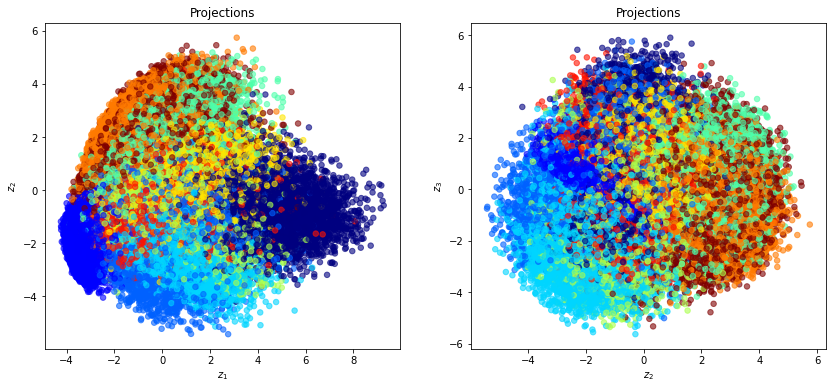

In [17]:
#lets compare with PCA (which will subtract the mean and SET the variance to unity)
#THIS CAN TAKE A WHILE TO RUN

n_components = 3
pca = PCA(n_components)
pca.fit(x_train_f.T)

#store results of PCA in a data frame
v_pca = pd.DataFrame(pca.transform(x_train_f.T), columns=['PCA%i' % i for i in range(n_components)])

#plot distribution of points
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(v_pca['PCA0'][:], v_pca['PCA1'][:], s=30, c=cs, alpha=0.6)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Projections')

plt.subplot(1, 2, 2)
plt.scatter(v_pca['PCA1'][:], v_pca['PCA2'][:], s=30, c=cs, alpha=0.6)
plt.xlabel('$z_2$')
plt.ylabel('$z_3$')
plt.title('Projections')

Text(0.5, 1.0, 'Resized to 28x28')

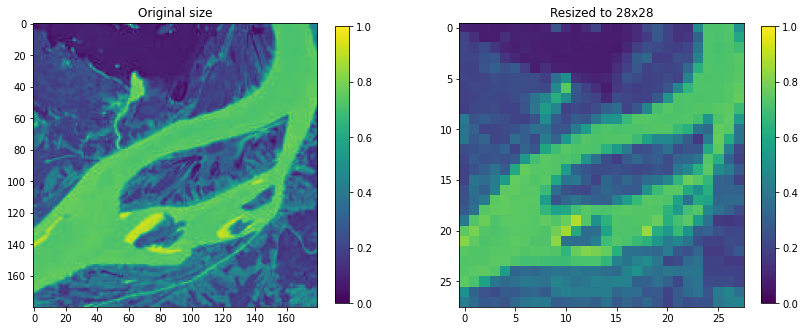

In [18]:
#how about we use the learnt bases from the digit-MNIST to approximate the river image?

#lets first reshape the river image to 28x28
A_gsc_r = cv2.resize(A_gsc[240:420, 100:280], (28, 28), interpolation = cv2.INTER_AREA)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(A_gsc[240:420, 100:280], cmap='viridis', vmin=0, vmax=1)
plt.colorbar(shrink=0.85)
plt.title('Original size')

plt.subplot(1, 2, 2)
plt.imshow(A_gsc_r, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(shrink=0.85)
plt.title('Resized to 28x28')

(784, 1)


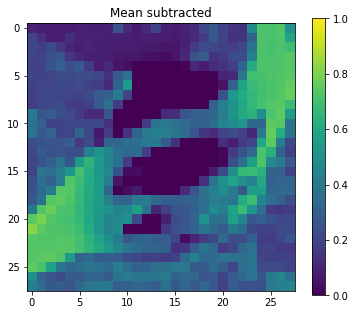

In [19]:
#some preprocessing, minus the mean you used earlier

A_gsc_r_f = np.reshape(A_gsc_r, (28*28, 1))
A_gsc_r_f_c = A_gsc_r_f - np.expand_dims(np.mean(x_train_f, axis=1), axis=1)

plt.figure(figsize=(6, 6))

plt.imshow(np.reshape(A_gsc_r_f_c, (28, 28)), cmap='viridis', vmin=0, vmax=1)
plt.colorbar(shrink=0.85)
plt.title('Mean subtracted')

print(A_gsc_r_f_c.shape)

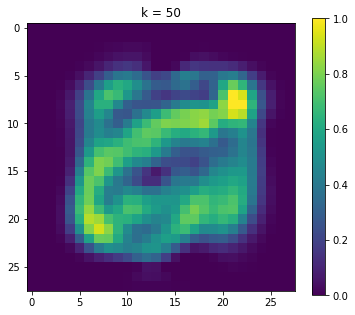

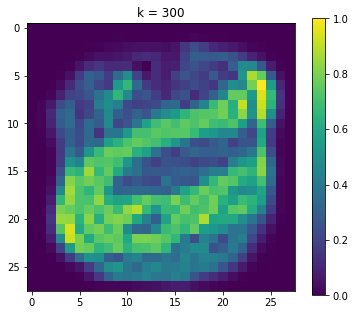

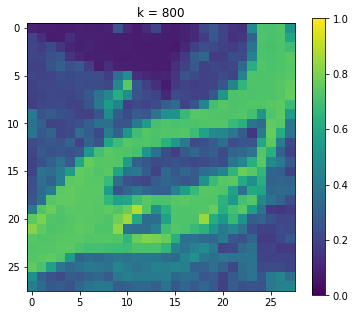

In [20]:
#try with a few ks

ks = [50, 300, 800]

for k in ks:
    v = (np.linalg.pinv(U[:, :k])@A_gsc_r_f_c).T
    A_gsc_r_f_c_hat = U[:, :k]@v.T
    A_gsc_r_f_hat = A_gsc_r_f_c_hat + np.expand_dims(np.mean(x_train_f, axis=1), axis=1)
    A_gsc_r_hat = np.reshape(A_gsc_r_f_hat.T, [-1, 28, 28])
    
    plt.figure(figsize=(6, 6))
    img = plt.imshow(np.squeeze(A_gsc_r_hat), cmap='viridis', vmin=0, vmax=1)
    plt.title("k = {}".format(k))
    plt.colorbar(shrink=0.85)